epoch 1, train_loss 0.0000, test_loss 0.0000
epoch 2, train_loss 0.0000, test_loss 0.0000
epoch 3, train_loss 0.0000, test_loss 0.0000
epoch 4, train_loss 0.0000, test_loss 0.0000
epoch 5, train_loss 0.0000, test_loss 0.0000
epoch 6, train_loss 0.0000, test_loss 0.0000
epoch 7, train_loss 0.0000, test_loss 0.0000
epoch 8, train_loss 0.0000, test_loss 0.0000
epoch 9, train_loss 0.0000, test_loss 0.0000
epoch 10, train_loss 0.0000, test_loss 0.0000


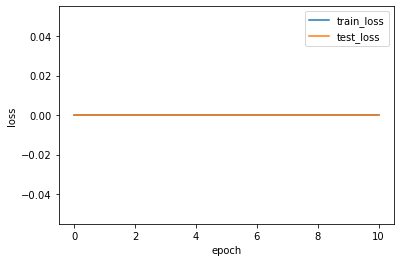

In [10]:
import torch
import torch.nn as nn
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data

# 获取数据集
batch_size = 100
feature_size = 200
def genMultiNormalData(mean, train_num, test_num, label):
    
    # 样本特征x的维度为200
    train_mean = mean
    
    # 协方差矩阵
    cov = np.eye(feature_size)
    train_size = (train_num, 1)
    test_size = (test_num, 1)
    
    # 生成训练集
    train_result = np.random.multivariate_normal(mean, cov, train_size)
    train_result = np.squeeze(train_result)

    # 生成测试集
    test_result = np.random.multivariate_normal(mean, cov, test_size)
    test_result = np.squeeze(test_result)
    
    train_labels = None
    test_labels = None
    
    # 生成标签
    if label == 0:
        train_labels = np.zeros(train_num)
        test_labels = np.zeros(test_num)
    else:
        train_labels = np.ones(train_num)
        test_labels = np.ones(test_num)
    return train_result, train_labels, test_result, test_labels

# 生成数据集1
mean = [i for i in range(1, 1+feature_size)]
x1_mean = torch.tensor(mean)
x1_train, x1_train_labels, x1_test, x1_test_labels = genMultiNormalData(x1_mean, 7000, 3000, 0)

# 生成数据集2
x2_mean = -1 * x1_mean
x2_train, x2_train_labels, x2_test, x2_test_labels = genMultiNormalData(x2_mean, 7000, 3000, 1)

x_train = np.append(x1_train, x2_train, axis = 0)
x_train_labels = np.append(x1_train_labels, x2_train_labels, axis = 0)
x_test = np.append(x1_test, x2_test, axis = 0)
x_test_labels = np.append(x1_test_labels, x2_test_labels, axis = 0)



x_train = torch.from_numpy(x_train).float()
x_train_labels = torch.from_numpy(x_train_labels).float()
x_test = torch.from_numpy(x_test).float()
x_test_labels = torch.from_numpy(x_test_labels).float()

# plt.figure(figsize=(12,8))
# plt.scatter(x_test[:, 0], x_test[:, 1],
#             c = x_test_labels, alpha = .4)


# 把数据放在数据库中
torch_dataset_x_train = Data.TensorDataset(x_train, x_train_labels)
torch_dataset_x_test = Data.TensorDataset(x_test, x_test_labels)

# 分批次吐数据
train_iter = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=torch_dataset_x_train,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

test_iter = Data.DataLoader(
    # 从数据库中每次抽出batch size个样本
    dataset=torch_dataset_x_test,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)
# print('x_test.shape', x_test.shape)
# print('x_test_labels.shape', x_test_labels.shape)
# print('x_train.shape', x_test.shape)
# print('x_train.shape', x_test_labels.shape)

# 定义模型参数
num_epochs = 10
lr = 0.1
num_inputs, num_outputs = feature_size, 1

W1 = torch.tensor(np.random.normal(0, 0.01, (num_outputs, num_inputs)), dtype=torch.double)
b1 = torch.zeros(num_outputs, dtype=torch.double)

# print('W1', W1)
params = [W1, b1]
for param in params:
    param.requires_grad_(requires_grad=True)

# 定义模型
net = nn.Sequential(
    nn.Linear(num_inputs, num_outputs),
    nn.Sigmoid(),
)

    
# 定义损失函数
loss = torch.nn.BCELoss()

# 定义优化函数
def SGD(params, lr):
    for param in params:
        param.data -= lr * param.grad
        
optimizer =torch.optim.SGD(net.parameters(), lr)
        
# 计算模型在数据集上的准确率
def evaluate_accuracy(data_iter, net, loss):
    acc_sum, n = 0.0, 0
    test_l_sum = 0.0
    for X, y in data_iter:
#         acc_sum += (net(X).argmax(dim=1) == y).float().sum().item()
        l = loss(net(X).squeeze(), y).sum()
        test_l_sum += l.item()
        n += y.shape[0]
        return acc_sum / n, test_l_sum / n

# 定义模型训练参数
def train(net, train_iter, test_iter, loss, num_epochs, batch_size, params=None, lr=None, optimizer=None):
    train_loss = []
    test_loss = []
    for epoch in range(num_epochs):
        train_acc_sum, train_l_sum, n = 0.0, 0.0, 0
        for X, y in train_iter:
            y_hat = net(X).squeeze()
            l = loss(y_hat, y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward()
            if optimizer is None:
                SGD(params, lr)
            else:
                optimizer.step()
                
            train_l_sum += l.item()
#             print('y_hat.shape', y_hat.shape)
#             print('y.shape', y.shape)
#             train_acc_sum += (y_hat.argmax(dim=1) == y).sum().item()
            n += y.shape[0]
        test_acc, test_l = evaluate_accuracy(test_iter, net, loss)
        train_loss.append(train_l_sum/n)
        test_loss.append(test_l)
       
        print('epoch %d, train_loss %.4f, test_loss %.4f' % (epoch + 1, train_l_sum / n, test_l))
    return train_loss, test_loss



train_loss, test_loss = train(net, train_iter, test_iter, loss, num_epochs, batch_size, params, lr, optimizer)

#画图
x = np.linspace(0, len(train_loss), len(train_loss))
plt.plot(x, train_loss, label = 'train_loss', linewidth=1.5)
plt.plot(x, test_loss, label='test_loss', linewidth = 1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()